## MAML paper implementations in TF 2.0


[**MAML: Model-Agnostic Meta-Learning for Fast Adaptation of Deep Networks**](https://arxiv.org/abs/1703.03400)

*Chelsea Finn, Pieter Abbeel, Sergey Levine*
> We propose an algorithm for meta-learning that is model-agnostic, in the sense that it is compatible with any model trained with gradient descent and applicable to a variety of different learning problems, including classification, regression, and reinforcement learning. The goal of meta-learning is to train a model on a variety of learning tasks, such that it can solve new learning tasks using only a small number of training samples. In our approach, the parameters of the model are explicitly trained such that a small number of gradient steps with a small amount of training data from a new task will produce good generalization performance on that task. In effect, our method trains the model to be easy to fine-tune. We demonstrate that this approach leads to state-of-the-art performance on two few-shot image classification benchmarks, produces good results on few-shot regression, and accelerates fine-tuning for policy gradient reinforcement learning with neural network policies.

This paper is pretty poggers actually.

Highly influenced by https://github.com/mari-linhares/tensorflow-maml

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.backend as keras_backend

import time
import random


np.random.seed(42)


"tensorflow version", tf.__version__

### Sine wave 1D regression task
On this simple regression task all three methods will be evaluated. 

In [ ]:
class SinusoidGenerator():
    ''' Sinusoid Generator

      p(T) is continuous, where the amplitude (a) varies within [0.1, 5.0]
      and the phase (b) varies within [0, π]. In the FOMAML paper the range 
      varies between varies within [0, 2π].
    '''
    def __init__(self, K=10, a=None, b=None, UL_b=np.pi):
        '''Amplitude a and phase b, upper limit of the phase UL_b'''
        self.a = a if a else np.random.uniform(0.1, 5.0)
        self.b = b if b else np.random.uniform(0, UL_b)

        self.K = K        
        self.sampled_points = None
        self.x = np.random.uniform(-5, 5, self.K)

    def f(self, x):
        '''Sinewave function'''
        return self.a * np.sin(x + self.b)

    def batch(self, x=None, generate_new=False):
        '''Returns a batch of size K.

        It also changes the sape of `x` to add a batch dimension to it.

        Args:
            x: Batch data, if given `y` is generated based on this data.
                Usually it is None. If None `self.x` is used.
            generate_new: Instead of using `x` argument the batch data is
                uniformly sampled.
        '''
        if x is None:
            if generate_new:
                x = np.random.uniform(-5, 5, self.K)
            else:
                x = self.x
        y = self.f(x)
        return x[:, None], y[:, None]

    def equally_spaced_samples(self, K=None):
        '''Returns `K` equally spaced samples.'''
        if K is None:
            K = self.K
        return self.batch(x=np.linspace(-5, 5, K))

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
x_av, y_av = np.zeros((100, 1)), np.zeros((100, 1))

for _ in range(100):
    x, y = SinusoidGenerator(K=100, UL_b=2*np.pi).equally_spaced_samples()
    ax.plot(x, y)
    x_av = x
    y_av = y_av + y
    
plt.title("100 Sinusoid samples, with a phase [0, 2π]")
ax.plot(x_av, y_av/100, color='black', label='average')
plt.show()

In [ ]:
fig, ax = plt.subplots(figsize=(6, 6))
x_av, y_av = np.zeros((100, 1)), np.zeros((100, 1))

for _ in range(100):
    x, y = SinusoidGenerator(K=100).equally_spaced_samples()
    ax.plot(x, y)
    x_av, y_av = x, y_av + y
    
plt.title("100 Sinusoid samples, with a phase [0, π]")
ax.plot(x_av, y_av/100, color='black', label='average')
plt.show()

### Generate sinusoid datasets

In [ ]:
def generate_dataset(K, train_size=20000, test_size=10):
    '''Generate train and test dataset.
    
    A dataset is composed of SinusoidGenerators that are able to provide
    a batch (`K`) elements at a time.
    '''
    def _generate_dataset(size):
        return [SinusoidGenerator(K=K) for _ in range(size)]
    return _generate_dataset(train_size), _generate_dataset(test_size) 

train_set, test_set = generate_dataset(K=10)

len(train_set), len(test_set)

#### Model definition


> *The regressor
is a neural network model with 2 hidden layers of size
40 with ReLU nonlinearities.*

In [ ]:
# Dense layers as defined in the MAML paper
class SineModel(keras.Model):
    def __init__(self):
        super().__init__()
        self.hidden1 = keras.layers.Dense(40, input_shape=(1,))
        self.hidden2 = keras.layers.Dense(40)
        self.out = keras.layers.Dense(1)
        
    def forward(self, x):
        x = keras.activations.relu(self.hidden1(x))
        x = keras.activations.relu(self.hidden2(x))
        x = self.out(x)
        return x

In [ ]:
def loss_function(pred_y, y):
    '''Mean Squared Error'''
    return keras_backend.mean(keras.losses.mean_squared_error(y, pred_y))


def np_to_tensor(list_of_numpy_objs):
    return (tf.convert_to_tensor(obj) for obj in list_of_numpy_objs)


def compute_loss(model, x, y, loss_fn=loss_function):
    logits = model.forward(x)
    mse = loss_fn(y, logits)
    return mse, logits


def compute_gradients(model, x, y, loss_fn=loss_function):
    with tf.GradientTape() as tape:
        loss, _ = compute_loss(model, x, y, loss_fn)
    return tape.gradient(loss, model.trainable_variables), loss


def apply_gradients(optimizer, gradients, variables):
    optimizer.apply_gradients(zip(gradients, variables))

    
def train_batch(x, y, model, optimizer):
    tensor_x, tensor_y = np_to_tensor((x, y))
    gradients, loss = compute_gradients(model, tensor_x, tensor_y)
    apply_gradients(optimizer, gradients, model.trainable_variables)
    return loss

Step 1000: loss = 3.682602828269667, Time to run 1000 steps = 3.60 seconds
Step 2000: loss = 3.507269348162957, Time to run 1000 steps = 3.73 seconds
Step 3000: loss = 3.4243654005878343, Time to run 1000 steps = 3.78 seconds
Step 4000: loss = 3.3796532613988317, Time to run 1000 steps = 3.82 seconds
Step 5000: loss = 3.3367480137591006, Time to run 1000 steps = 3.21 seconds
Step 6000: loss = 3.311786982512088, Time to run 1000 steps = 3.24 seconds
Step 7000: loss = 3.256172275099643, Time to run 1000 steps = 3.23 seconds
Step 8000: loss = 3.2370946868028456, Time to run 1000 steps = 3.24 seconds
Step 9000: loss = 3.216440779827697, Time to run 1000 steps = 3.58 seconds
Step 10000: loss = 3.2152596503365247, Time to run 1000 steps = 3.09 seconds
Step 11000: loss = 3.204249460873505, Time to run 1000 steps = 3.01 seconds
Step 12000: loss = 3.2031398741173547, Time to run 1000 steps = 3.40 seconds
Step 13000: loss = 3.183749022602657, Time to run 1000 steps = 3.35 seconds
Step 14000: los

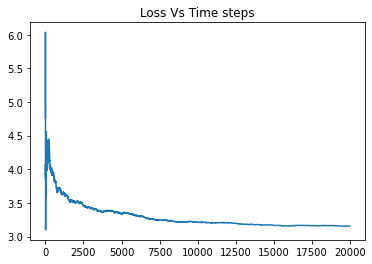

In [16]:
# Naive approach to training on different tasks,
def train_model(dataset, epochs=1, lr=0.001, log_steps=1000):
    model = SineModel()
    optimizer = keras.optimizers.Adam(learning_rate=lr)

    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()
        for i, sinusoid_generator in enumerate(dataset):
            x, y = sinusoid_generator.batch()
            loss = train_batch(x, y, model, optimizer)
            total_loss += loss
            curr_loss = total_loss / (i + 1.0)
            losses.append(curr_loss)
            
            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {:.2f} seconds'.format(
                    i, curr_loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.title('Loss Vs Time steps')
        plt.show()
    return model

# Prevent conversion float64, float32 warnings
tf.keras.backend.set_floatx('float64')

neural_net = train_model(train_set)

A neural network trained for this task, should converge to the average of the sinusoids curves.

In [ ]:
# neural_net = SineModel()

def plot_model_comparison_to_average(model, ds, model_name='neural network', K=10):
    '''Compare model to average.

    Computes mean of training sine waves actual `y` and compare to
    the model's prediction to a new sine wave, the intuition is that
    these two plots should be similar.
    '''
    sinu_generator = SinusoidGenerator(K=K)

    # calculate average prediction
    avg_pred = []
    for i, sinusoid_generator in enumerate(ds):
        x, y = sinusoid_generator.equally_spaced_samples()
        avg_pred.append(y)

    x, _ = sinu_generator.equally_spaced_samples()    
    avg_plot, = plt.plot(x, np.mean(avg_pred, axis=0), '--')

    # calculate model prediction
    model_pred = model.forward(tf.convert_to_tensor(x))
    model_plot, = plt.plot(x, model_pred.numpy())

    # plot
    plt.legend([avg_plot, model_plot], ['Average', model_name])
    plt.show()
 
plot_model_comparison_to_average(neural_net, train_set)

### Transfer learning?

Here we try to use the trained neural network to initialize the weights for a model trained on new sine wave functions.

The new sine wave is treated as a new task. Our model was trained on a bunch of sine wave tasks and we're trying to use this previous knowledge to initialize the weights of the model for a new task.

In [ ]:
def copy_model(model, x):
    '''Copy model weights to a new model.
    
    Args:
        model: model to be copied.
        x: An input example. This is used to run
            a forward pass in order to add the weights of the graph
            as variables.
    Returns:
        A copy of the model.
    '''
    copied_model = SineModel()
    
    # If we don't run this step the weights are not "initialized"
    # and the gradients will not be computed.
    copied_model.forward(tf.convert_to_tensor(x))
    
    copied_model.set_weights(model.get_weights())
    return copied_model
  

def eval_sine_test(model, optimizer, x, y, x_test, y_test, 
                   num_steps=(0, 1, 10)):
    '''Evaluate how the model fits to the curve training for `fits` steps.
    
    Args:
        model: Model evaluated.
        optimizer: Optimizer to be for training.
        x: Data used for training.
        y: Targets used for training.
        x_test: Data used for evaluation.
        y_test: Targets used for evaluation.
        num_steps: Number of steps to log.
    '''
    fit_res = []
    
    tensor_x_test, tensor_y_test = np_to_tensor((x_test, y_test))
    
    # If 0 in fits we log the loss before any training
    if 0 in num_steps:
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        fit_res.append((0, logits, loss))
        
    for step in range(1, np.max(num_steps) + 1):
        train_batch(x, y, model, optimizer)
        loss, logits = compute_loss(model, tensor_x_test, tensor_y_test)
        if step in num_steps:
            fit_res.append(
                (
                    step,
                    logits,
                    loss
                )
            )
    return fit_res


def eval_sinewave_for_test(model, sinusoid_generator=None, 
                           num_steps=(0, 1, 10), lr=0.01, plot=True,
                           title=None):
    '''Evaluates how the sinewave addapts at dataset.
    
    The idea is to use the pretrained model as a weight initializer and
    try to fit the model on this new dataset.
    
    Args:
        model: Already trained model.
        sinusoid_generator: A sinusoidGenerator instance.
        num_steps: Number of training steps to be logged.
        lr: Learning rate used for training on the test data.
        plot: If plot is True than it plots how the curves are fitted along
            `num_steps`.
    
    Returns:
        The fit results. A list containing the loss, logits and step. For
        every step at `num_steps`.
    '''
    
    if sinusoid_generator is None:
        sinusoid_generator = SinusoidGenerator(K=10)
        
    # generate equally spaced samples for ploting
    x_test, y_test = sinusoid_generator.equally_spaced_samples(100)
    
    # batch used for training
    x, y = sinusoid_generator.batch()
    
    # copy model so we can use the same model multiple times
    copied_model = copy_model(model, x)
    
    # use SGD for this part of training as described in the paper
    optimizer = keras.optimizers.SGD(learning_rate=lr)
    
    # run training and log fit results
    fit_res = eval_sine_test(copied_model, optimizer, x, y, x_test, y_test, num_steps)
    
    # plot
    train, = plt.plot(x, y, '^')
    ground_truth, = plt.plot(x_test, y_test)
    plots = [train, ground_truth]
    legend = ['Training Points', 'True Function']
    for n, res, loss in fit_res:
        cur, = plt.plot(x_test, res[:, 0], '--')
        plots.append(cur)
        legend.append(f'After {n} Steps')
    plt.legend(plots, legend)
    plt.title(title)
    plt.ylim(-5, 5)
    plt.xlim(-6, 6)
    if plot:
        plt.show()
    
    return fit_res

### Try to use transfer learning for different sine waves

In [ ]:
for index in np.random.randint(0, len(test_set), size=3):
    eval_sinewave_for_test(neural_net, test_set[index])

### MAML

![](https://cdn-images-1.medium.com/max/1600/1*_pgbRGIlmCRsYNBHl71mUA.png)

In [20]:
# Naive approach to training on different tasks,
def train_maml(model, dataset, epochs=1, batch_size=1, lr_inner=0.01, log_steps=1000):
    optimizer = keras.optimizers.Adam()

    # Step 2: instead of checking for convergence, we train for a number
    # of epochs
    for epoch in range(epochs):
        losses = []
        total_loss = 0
        start = time.time()

        # Step 3, 4
        for i, t in enumerate(random.sample(dataset, len(dataset))):
            x, y = np_to_tensor(t.batch())
            model.forward(x) # forward to initialize weights
            with tf.GradientTape() as test_tape:

              # Step 5
              with tf.GradientTape() as train_tape:
                train_loss, _ = compute_loss(model, x, y)

                # Step 6
                gradients = train_tape.gradient(train_loss, model.trainable_variables)
                k = 0
                model_copy = copy_model(model, x)
                for j in range(len(model_copy.layers)):
                    model_copy.layers[j].kernel = tf.subtract(model.layers[j].kernel,
                                                            tf.multiply(lr_inner, gradients[k]))
                    model_copy.layers[j].bias = tf.subtract(model.layers[j].bias,
                                                          tf.multiply(lr_inner, gradients[k+1]))
                    k += 2
                # Step 8
                test_loss, logits = compute_loss(model_copy, x, y)
            # Step 8
            gradients = test_tape.gradient(test_loss, model.trainable_variables)
            optimizer.apply_gradients(zip(gradients, model.trainable_variables))

            total_loss += test_loss 
            loss = total_loss / (i+1.0)
            losses.append(loss)

            if i % log_steps == 0 and i > 0:
                print('Step {}: loss = {}, Time to run {} steps = {}'.format(i, loss, log_steps, time.time() - start))
                start = time.time()
        plt.plot(losses)
        plt.show()

    return model

Step 1000: loss = 2.658263170327265, Time to run 1000 steps = 18.498526334762573
Step 2000: loss = 2.113955337171177, Time to run 1000 steps = 18.44978666305542
Step 3000: loss = 1.7468329806613763, Time to run 1000 steps = 18.4882071018219
Step 4000: loss = 1.5012999620462695, Time to run 1000 steps = 19.690840005874634
Step 5000: loss = 1.3356869244600924, Time to run 1000 steps = 21.224682092666626
Step 6000: loss = 1.2055953428316233, Time to run 1000 steps = 19.874244689941406
Step 7000: loss = 1.1161771240905338, Time to run 1000 steps = 19.34698176383972
Step 8000: loss = 1.0434867169402993, Time to run 1000 steps = 19.496849298477173
Step 9000: loss = 0.9809492100846083, Time to run 1000 steps = 18.67917513847351
Step 10000: loss = 0.9266894403846238, Time to run 1000 steps = 18.604231119155884
Step 11000: loss = 0.8804018323596616, Time to run 1000 steps = 18.90736675262451
Step 12000: loss = 0.8443623496306473, Time to run 1000 steps = 20.131417274475098
Step 13000: loss = 0.

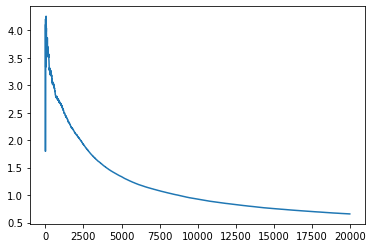

In [21]:
maml = SineModel()
train_maml(maml, train_set)

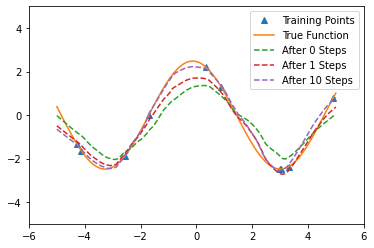

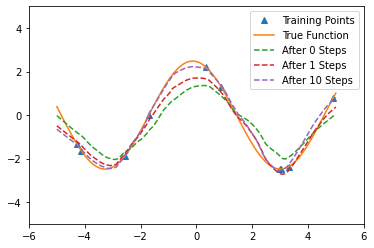

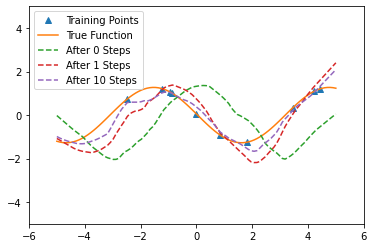

In [22]:
for index in np.random.randint(0, len(test_set), size=3):
    eval_sinewave_for_test(maml, test_set[index])

### MAML vs regular Neural Network

In [23]:
def compare_maml_and_neural_net(maml, neural_net, sinusoid_generator, num_steps=list(range(10)),
                                intermediate_plot=True, marker='x', linestyle='--'):
    '''Compare the loss of a MAML model and a neural net.
    
    Fits the models for a new task (new sine wave) and then plot
    the loss of both models along `num_steps` interactions.
    
    Args:
        maml: An already trained MAML.
        neural_net: An already trained neural net.
        num_steps: Number of steps to be logged.
        intermediate_plot: If True plots intermediate plots from
            `eval_sinewave_for_test`.
        marker: Marker used for plotting.
        linestyle: Line style used for plotting.
    '''
    fit_maml = eval_sinewave_for_test(maml, sinusoid_generator, 
                                      plot=intermediate_plot, title="MAML")
    fit_neural_net = eval_sinewave_for_test(neural_net, sinusoid_generator, 
                                            plot=intermediate_plot,
                                            title="Neural Network")
    
    fit_res = {'MAML': fit_maml, 'Neural Net': fit_neural_net}
    
    legend = []
    for name in fit_res:
        x = []
        y = []
        for n, _, loss in fit_res[name]:
            x.append(n)
            y.append(loss)
        plt.title("MSE loss")
        plt.plot(x, y, marker=marker, linestyle=linestyle)
        plt.xticks(num_steps)
        legend.append(name)
    plt.legend(legend)
    plt.show()

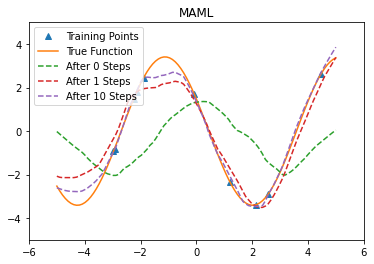

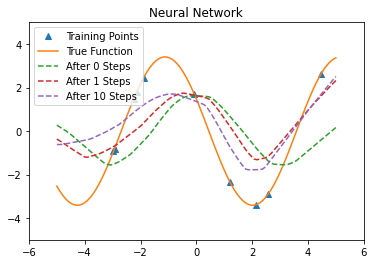

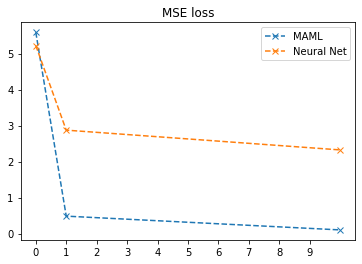

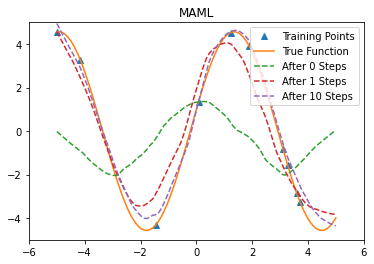

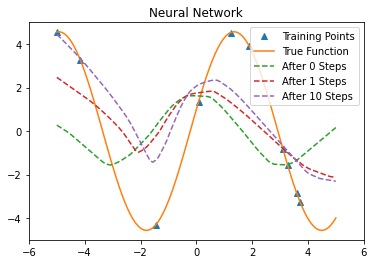

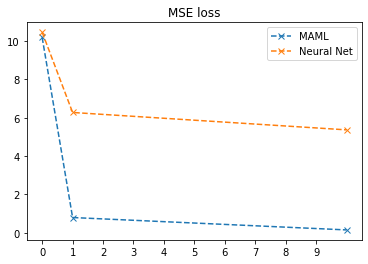

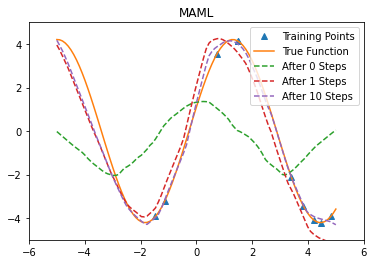

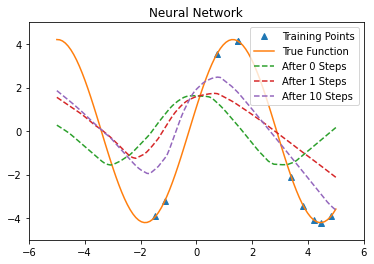

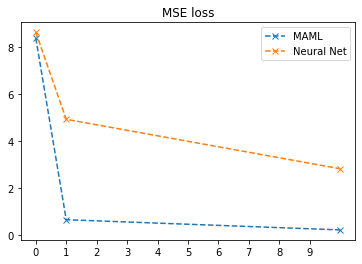

In [24]:
for index in np.random.randint(0, len(test_set), size=3):
    compare_maml_and_neural_net(maml, neural_net, test_set[index])

### MAML with Reinforcement Learning

> The gradient updates are computed using vanilla policy gradient (REINFORCE (Williams, 1992), and we use trust-region policy optimization (TRPO) as the meta-optimizer (Schulman et al., 2015). In order to avoid computing third derivatives, we use finite differences to compute the Hessian-vector products for TRPO. 

An example of simple a2c using bsuite and baselines

**TODO: Extend this example to MAML with Reinforcement Learning**

In [7]:
import bsuite

# Baseline 
from baselines.common.vec_env import dummy_vec_env
from baselines.a2c import a2c
from bsuite.utils import gym_wrapper

import tensorflow as tf


SAVE_PATH_PPO = '/tmp/bsuite/a2c'

def _load_env():
    raw_env = bsuite.load_and_record(
      bsuite_id='bandit_noise/0', 
      save_path=SAVE_PATH_PPO, logging_mode='csv', overwrite=True)
    return gym_wrapper.GymFromDMEnv(raw_env)
env = dummy_vec_env.DummyVecEnv([_load_env])

a2c.learn(
    env=env, network='mlp', lr=1e-3, gamma=.99,
    total_timesteps=10000, nsteps=100)

Loaded bsuite_id: bandit_noise/0.
Logging results to CSV file for each bsuite_id in /tmp/bsuite/a2c.
input shape is (1, 1)
---------------------------------
| eplenmean          | nan      |
| eprewmean          | nan      |
| explained_variance | 1.19e-07 |
| fps                | 116      |
| nupdates           | 1        |
| policy_entropy     | 2.4      |
| total_timesteps    | 100      |
| value_loss         | 0.476    |
---------------------------------
---------------------------------
| eplenmean          | nan      |
| eprewmean          | nan      |
| explained_variance | 0        |
| fps                | 2196     |
| nupdates           | 100      |
| policy_entropy     | 2.38     |
| total_timesteps    | 10000    |
| value_loss         | 0.106    |
---------------------------------


In [2]:
# stable-baseline
# import gym

# from stable_baselines.common.policies import MlpPolicy
# from stable_baselines import TRPO

# env = gym.make('CartPole-v1')

# model = TRPO(MlpPolicy, env, verbose=1)
# model.learn(total_timesteps=25000)
# model.save("trpo_cartpole")

# del model # remove to demonstrate saving and loading

# model = TRPO.load("trpo_cartpole")

# obs = env.reset()
# while True:
#     action, _states = model.predict(obs)
#     obs, rewards, dones, info = env.step(action)
#     env.render()